<a href="https://colab.research.google.com/github/Justinezgh/ssnpe_desc_project/blob/main/notebooks/dev/NLE_lensing_pb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet chainconsumer
!git clone https://github.com/DifferentiableUniverseInitiative/sbi_lens
!git clone https://github.com/Justinezgh/ssnpe_desc_project.git

remote: Total 988 (delta 150), reused 208 (delta 112), pack-reused 641
Receiving objects: 100% (988/988), 82.46 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (564/564), done.
Updating files: 100% (47/47), done.
Cloning into 'ssnpe_desc_project'...
remote: Enumerating objects: 1027, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1027 (delta 15), reused 53 (delta 15), pack-reused 974
Receiving objects: 100% (1027/1027), 864.05 MiB | 18.34 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (333/333), done.


In [ ]:
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import pickle
import argparse
import os
from chainconsumer import ChainConsumer

import numpy as np
import jax
import jax.numpy as jnp

import numpyro.distributions as dist
from numpyro.handlers import condition, trace, seed

import jax_cosmo as jc

from haiku._src.nets.resnet import ResNet18
import optax
import haiku as hk

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from sbi_lens.simulator.LogNormal_field import lensingLogNormal
from sbi_lens.config import config_lsst_y_10
from sbi_lens.normflow.models import (
  ConditionalRealNVP,
  AffineCoupling
)


In [ ]:
total_steps = 10_000
score_weight = 1e-5
exp_id = 1
seed = 1
n_flow_layers = 8
n_bijector_layers = 5
activ_fun = 0
lr_schedule = 1

PATH = "npe_{}_{}_{}_{}_{}_{}_{}_{}".format(
  total_steps,
  score_weight,
  exp_id,
  seed,
  n_flow_layers,
  n_bijector_layers,
  activ_fun,
  lr_schedule
)


print('lr schedule ',lr_schedule)

######## TRAINING PARAMS ########
print('######## TRAINING PARAMS ########')
total_steps = total_steps
batch_size = 256
tmp = list(range(0, 101_000, 5000))
tmp[0] = 1000
nb_simulations_allow = 10_000
score_weight = score_weight


######## CONFIG LSST Y 10 ########
print('######## CONFIG LSST Y 10 ########')
dim              = 6

N                = config_lsst_y_10.N
map_size         = config_lsst_y_10.map_size
sigma_e          = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins            = config_lsst_y_10.nbins
a                = config_lsst_y_10.a
b                = config_lsst_y_10.b
z0               = config_lsst_y_10.z0

truth            = config_lsst_y_10.truth

params_name      = config_lsst_y_10.params_name_latex

######## LOAD OBSERVATION AND REFERENCES POSTERIOR ########
print('######## LOAD OBSERVATION AND REFERENCES POSTERIOR ########')

# load reference posterior
sample_ff = jnp.load(
  './sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy'
)

# plot observed mass map
m_data = jnp.load('./sbi_lens/sbi_lens/data/m_data__256N_10ms_27gpa_0.26se.npy')

######## DATASET ########
print('######## DATASET ########')

dataset = np.load('./ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_density_proposal.npz', allow_pickle=True)['arr_0']

######## COMPRESSOR ########
print('######## COMPRESSOR ########')

compressor = hk.transform_with_state(
    lambda y : ResNet18(dim)(y, is_training=False)
)

a_file = open('./sbi_lens/sbi_lens/data/params_compressor/opt_state_resnet_vmim.pkl', "rb")
opt_state_resnet= pickle.load(a_file)

a_file = open('./sbi_lens/sbi_lens/data/params_compressor/params_nd_compressor_vmim.pkl', "rb")
parameters_compressor= pickle.load(a_file)

m_data_comressed, _ = compressor.apply(
  parameters_compressor,
  opt_state_resnet,
  None,
  m_data.reshape([1, N, N, nbins])
)

lr schedule  1
######## TRAINING PARAMS ########
######## CONFIG LSST Y 10 ########
######## LOAD OBSERVATION AND REFERENCES POSTERIOR ########
######## DATASET ########
######## COMPRESSOR ########


In [ ]:
inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()['score']))[0])
dataset_y = jnp.delete(dataset.item()['y'], inds, axis = 0)
dataset_score = jnp.delete(dataset.item()['score'], inds, axis = 0)
dataset_theta = jnp.delete(dataset.item()['theta'], inds, axis = 0)

In [ ]:
plt.figure()
c = ChainConsumer()
c.add_chain(dataset_theta, parameters=params_name, name='kept sample', shade_alpha = 0.5)
c.add_chain(dataset.item()['theta'][inds], parameters=params_name, name='deleted sample', shade_alpha = 0.5)
fig = c.plotter.plot(
  figsize=1.2,
  truth=truth
)

AssertionError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
c = ChainConsumer()
c.add_chain(dataset_y, parameters=params_name, name='compressed stat', shade_alpha = 0.5)
fig = c.plotter.plot(
  figsize=1.2
)

In [ ]:
scale_y = jnp.std(dataset_y, axis=0) / 0.07
shift_y = jnp.mean(dataset_y / scale_y, axis=0) - 0.5

normalized_y = tfb.Chain([tfb.Scale(scale_y),tfb.Shift(shift_y)]).inverse(dataset_y)

<Figure size 640x480 with 0 Axes>

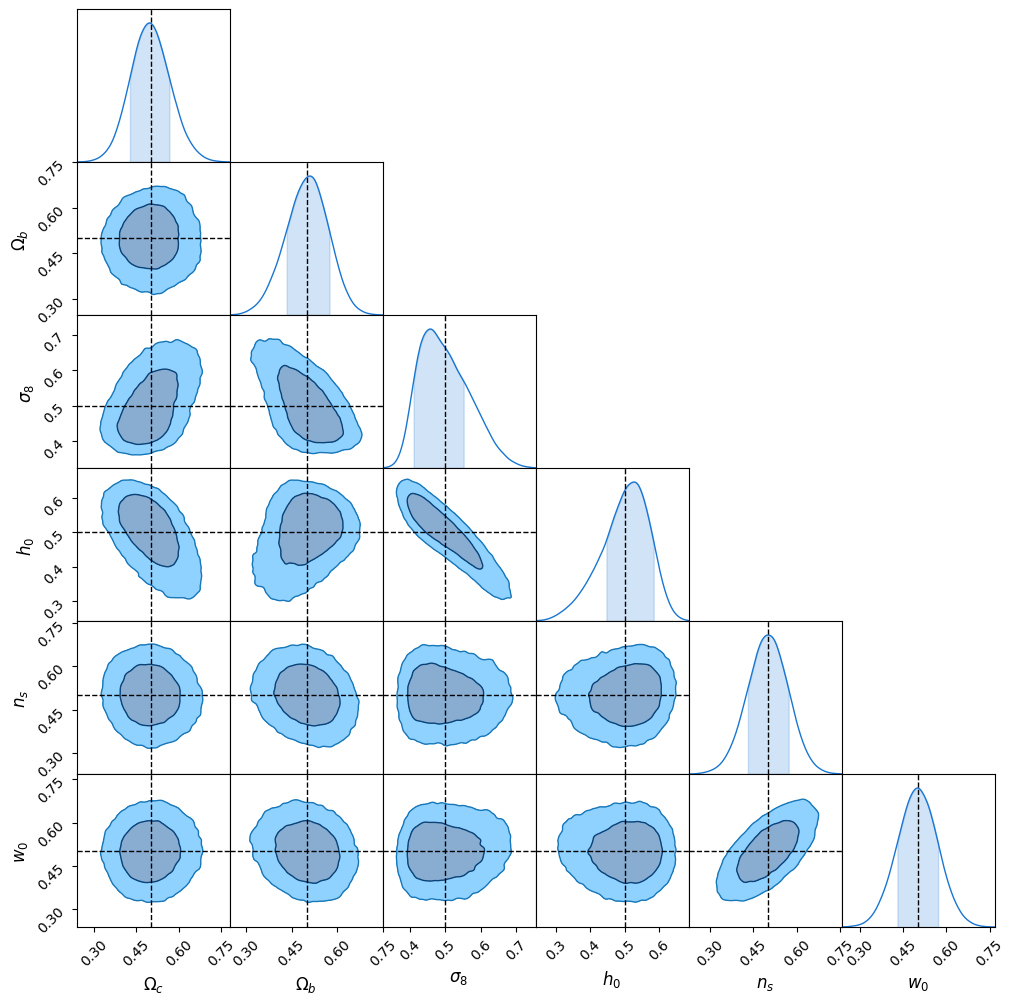

In [ ]:
plt.figure()
c = ChainConsumer()
c.add_chain(normalized_y, parameters=params_name, name='compressed stat normalized', shade_alpha = 0.5)
fig = c.plotter.plot(
  figsize=1.2,
  truth=[0.5] * 6
)

In [ ]:
######## CREATE NDE ########
print('######## NDE ########')

from sbi_lens.normflow.models import ConditionalRealNVP, AffineSigmoidCoupling

bijector_layers = [128] * n_bijector_layers

if activ_fun == 0 :
  activ_fun = jax.nn.silu
  activ_fun_string = 'silu'
elif activ_fun == 1:
  activ_fun = jnp.sin
  activ_fun_string = 'sin'

bijector_npe = partial(
    AffineSigmoidCoupling,
    layers=bijector_layers,
    activation=activ_fun,
    n_components=16
  )

NF_npe = partial(
  ConditionalRealNVP,
  n_layers=n_flow_layers,
  bijector_fn=bijector_npe)

class SmoothNPE(hk.Module):
    def __call__(self, y):
        nvp = NF_npe(dim)(y)
        return tfd.TransformedDistribution(
            nvp,
            tfb.Chain([tfb.Scale(scale_y), tfb.Shift(shift_y)]))


nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(theta).log_prob(y).squeeze()))

log_prob_fn = lambda params, theta, y : nvp_nd.apply(params, theta, y)

nvp_sample_nd = hk.transform(
lambda theta : SmoothNPE()(theta).sample(len(sample_ff), seed=hk.next_rng_key())
  )

######## LOSSES & UPDATE FUN ########
print('######## LOSSES & UPDATE FUN ########')

def loss_nll(
    params,
    mu,
    batch,
    weight,
    score,
    weight_score
):

    lp, out = jax.vmap(
      jax.value_and_grad(lambda theta, x: log_prob_fn(params, theta.reshape([1,dim]), x.reshape([1,dim])).squeeze())
    )(mu, batch)

    return - jnp.mean(lp) + weight_score * jnp.sum((out - score)**2, axis=-1).mean()

@jax.jit
def update(params, opt_state, mu, batch, w, score, weight_score):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
        w,
        score,
        weight_score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state


######## TRAIN ########
print('######## TRAIN ########')

params = nvp_nd.init(
    jax.random.PRNGKey(seed),
    0.5 * jnp.ones([1, dim]),
    0.5 * jnp.ones([1, dim])
)


#optimizer
if lr_schedule == 0:
  print('lr schedure 0')
  lr_scheduler = optax.piecewise_constant_schedule(
      init_value=0.001,
      boundaries_and_scales={
        int(total_steps*0.4):0.2,
        int(total_steps*0.6):0.3,
        int(total_steps*0.8):0.4,
        int(total_steps*1):0.5,
     }
  )
  lr_schedule_string = 'p_c_s'

elif lr_schedule == 1:
  lr_scheduler = optax.exponential_decay(
      init_value = 0.001,
      transition_steps = total_steps // 50,
      decay_rate = 0.9,
      end_value = 1e-5
  )
  lr_schedule_string = 'exp_decay'

optimizer = optax.adam(lr_scheduler)
opt_state = optimizer.init(params)

######## NDE ########
######## LOSSES & UPDATE FUN ########
######## TRAIN ########


In [ ]:
batch_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
  inds = np.random.randint(0, nb_simulations_allow, batch_size)
  ex_theta = dataset_theta[inds]
  ex_y = dataset_y[inds]
  ex_score = dataset_score[inds]
  ex_weight = None

  if not (jnp.isnan(ex_y).any() or jnp.isnan(ex_score).any()):


    l, params, opt_state = update(
        params,
        opt_state,
        ex_theta,
        ex_y,
        ex_weight,
        ex_score,
        score_weight
    )

    batch_loss.append(l)
    lr_scheduler_store.append(lr_scheduler(batch))
    pbar.set_description(f"loss {l:.3f}")

    if jnp.isnan(l):
      print('NAN')
      break

loss -5.514: 100%|██████████| 10001/10001 [07:02<00:00, 23.67it/s]


Text(0.5, 1.0, 'Batch Loss')

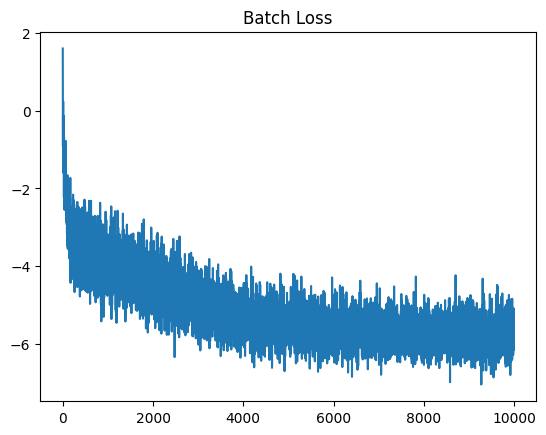

In [ ]:
# save plot loss
plt.figure()
plt.plot(batch_loss[10:])
plt.title('Batch Loss')

In [ ]:
def unnormalized_log_prob(theta):

      oc, ob, s8, h0, ns, w0 = theta

      prior = dist.TruncatedNormal(0.2664, 0.2, low=0).log_prob(oc)
      prior += dist.Normal(0.0492, 0.006).log_prob(ob)
      prior += dist.Normal(0.831, 0.14).log_prob(s8)
      prior += dist.Normal(0.6727, 0.063).log_prob(h0)
      prior += dist.Normal(0.9645, 0.08).log_prob(ns)
      prior += dist.TruncatedNormal(-1.0, 0.9, low=-2.0, high=-0.3).log_prob(w0)

      likelihood = log_prob_fn(params, theta.reshape([1,dim]), jnp.array(m_data_comressed).reshape([1,dim]))

      return likelihood + prior

# Initialize the HMC transition kernel.
num_results = int(1e4)
num_burnin_steps = int(5e2)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1e-2),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@jax.jit
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=jnp.array(truth),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      seed = jax.random.PRNGKey(0))

  return samples, is_accepted


samples_hmc, is_accepted_hmc = run_chain()

In [ ]:
sample_nd = samples_hmc[is_accepted_hmc].reshape([-1,6])
inds = np.random.randint(0, len(sample_nd), len(sample_ff))

sample_nd = sample_nd[inds,...]

<Figure size 640x480 with 0 Axes>

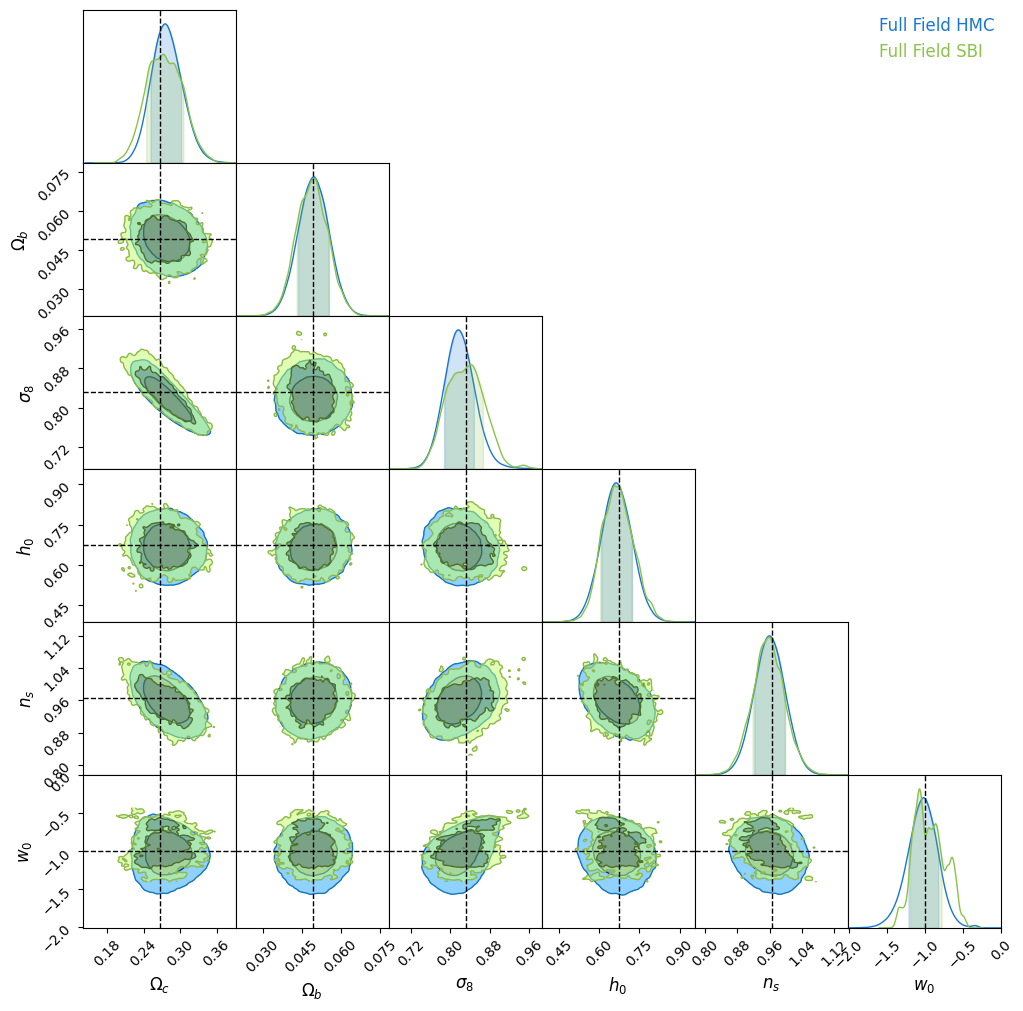

In [ ]:
plt.figure()
c = ChainConsumer()
c.add_chain(sample_ff, parameters=params_name, name='Full Field HMC', shade_alpha = 0.5)
c.add_chain(sample_nd, parameters=params_name, name='Full Field SBI', shade_alpha = 0.5)
fig = c.plotter.plot(
  figsize=1.2,
  truth=truth,
  extents=[[t - 5 * np.std(sample_ff[:,i]),
            t + 5 * np.std(sample_ff[:,i])] for i,t in enumerate(truth)]
)